# Lab - Dimension Reduction
## Introduction to Matrix Completion

---

**Course:** Dimension Reduction

**Authors:** Fathnelle & Mamadou

**Date:** February 2026

---

In [ ]:
# imports
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd

---
## I - Data Comprehension

### 1- Data exploration

In [13]:
data = pd.read_csv('/content/sample_data/ml-latest-small/ratings.csv')
print(data.head(2))

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247


In [7]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


In [8]:
print("Total numbers of ratings :", len(data))
print("Numbers of users:", data["userId"].nunique())
print("Numbers of movies :", data["movieId"].nunique())

Total numbers of ratings : 100836
Numbers of users: 610
Numbers of movies : 9724


count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


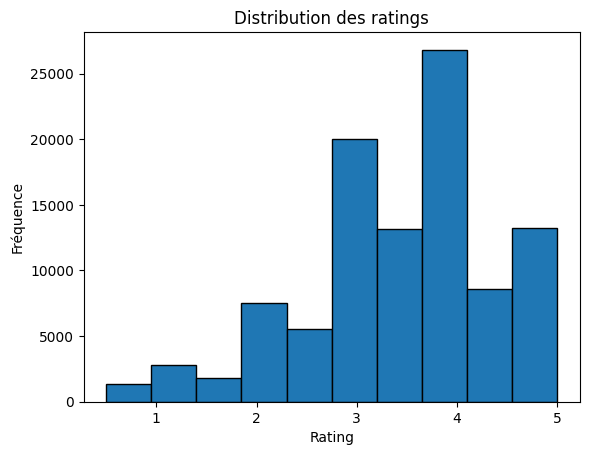

In [9]:
# descriptive statistics of the ratings
print(data["rating"].describe())

plt.hist(data["rating"], bins=10, edgecolor='black')
plt.title("Distribution des ratings")
plt.xlabel("Rating")
plt.ylabel("Fréquence")
plt.show()


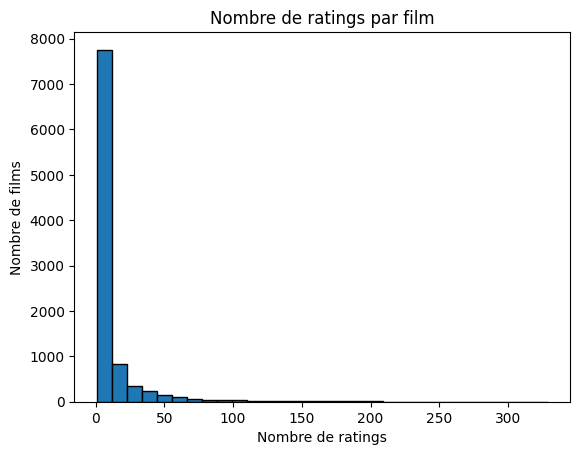

In [10]:
# numbers of ratings per movie

ratings_per_movie = data.groupby("movieId")["userId"].count()

plt.hist(ratings_per_movie, bins=30, edgecolor='black')
plt.title("Nombre de ratings par film")
plt.xlabel("Nombre de ratings")
plt.ylabel("Nombre de films")
plt.show()


### 2- Building of the matrix user $\times$ movie and assessing sparisty

In [12]:

user_ids = data["userId"].astype("category").cat.codes
movie_ids = data["movieId"].astype("category").cat.codes

ratings = data["rating"].values

n_users = user_ids.nunique()
n_movies = movie_ids.nunique()

Y = coo_matrix((ratings, (user_ids, movie_ids)), shape=(n_users, n_movies))

print("Shape of the matrix :", Y.shape)

# Rate of sparsity
total_entries = n_users * n_movies
observed_entries = len(ratings)

sparsity = 1 - observed_entries / total_entries

print(f"Rate sparsity: {sparsity:.2%}")

Shape of the matrix : (610, 9724)
Rate sparsity: 98.30%


We can notice that $610 \times 9724 = 6$ millions but we just have more than 100 000 values available. The MovieLens dataset is highly sparse, with more than 98% missing entries. The singular values exhibit a fast decay, suggesting that the rating matrix can be well approximated by a low-rank structure. This justifies the use of low-rank matrix completion algorithms such as SVP, SVT and ADMiRA.


## II- Preliminary questions and algorithms explorations

### 1- Formalisation of the task



This projects aims to use some algorithm to complete a huge rating movie matrix. Many users of Netflix rated some movies they watched. And based on these ratings, the goal is to predict what they would rate if they saw the other movies. If the image of the matrix in the task is considered (User in line and movies in column), the task would be to fill all the zeros values of the matrix.

In the paper task, it is designed formally as :

The movie ratings are represented as a matrix $Y \in \mathbb{R}^{n \times m}$, where:

- \(n\): number of users  
- \(m\): number of movies  

As said before, each user rates a certain amount of movies. So, it is defined $S \subset \{1,\dots,n\} \times \{1,\dots,m\}$ the set of observed (user, movie) pairs. We define the observed rating matrix $Y^S$ by:

$$
Y^S_{ij} =
\begin{cases}
Y_{ij} & \text{if } (i,j) \in S, \\
0 & \text{otherwise.}
\end{cases}
$$

The optimization problem in order to complete the matrix is written as:

$$
\hat{X}_r =
\arg\min_{\operatorname{rank}(X) \le r}
\;\|X^S - Y^S\|_2^2,
$$

where $X^S$ denotes the restriction of $X$ to the observed entries in $S$.

The information from the obtained matrix needs to match with the information from the previous initial sparse matrix.

### 2- How is this problem related to the course?

This problem is related to the course because the completed matrix will be a good predictor if it arrives to use the latent structure of the sparse matrix without hallucinating. If an algorithm achieves to fill the sparse matrix with having a huge rank, one can question where those superfluous informations came from as it is assumed that the information into the sparse matrix lie into a lower rank/dimension (instrinsic) than the full rank.

Getting back to the low-rank hypothesis on the sparse data, it makes sense as shown in the introduction of the course. The fact that a sample of the users ratings are used can helps points out the true factors of their taste and these true factors are the ones that will be leading any rates they should make. These factors/determinants are believed lower than the classical rank of the sparse matrix.

The dimension reduction course exactly aims to identify those latent factors/ this low rank and then try to extract them in order to work on the right useful space of information. The more the algorithm will find the latent determinant structure of the sparse matrix $X$, the better it will fill it to $Y$. This is why the constraint is important and how it tied up to the course.

### 3- To which of the sparse linear regression algorithms (matching pursuit, iterative hard thresholding, convex relaxation) can you compare each of the three completion algorithms?

In this part, the goal is to unfold each algorithm and compare them to a sparse regression method.

### 3-1- Singular Value Projection(SVP) \& Iteractive Hard Thresholdind(IHT)

SVP (Singular Value Projection) aims to apply iteratively at each step a singular value decomposition to the gradient descended last matrix $X_{t}^{'}$.

$$X_{t}^{'} = X_{t} + 1 \times (Y - X_{t}^{S})$$

The loss depending on only entries of the matrix, this last step is just a gradient descent step with $\eta = 1$ as learning rate. It is observed that the loss is only computed on the ground truth and the step is optimising the ongoing completion matrix.

$$U,\Sigma,D = SVD(X_{t}^{'})$$

 Using that decomposition, the next $X_{t+1}$ is reconstructed using the same components except that sigma keeps only it largest r sigma values.

 $$X_{t+1} = U \Sigma_{r}V^⊤$$

It’s the same idea as iterative hard thresholding, but with two key differences.
At the vector level, IHT basically does a gradient descent step and keeps only the k largest parameters:

$$z = x - \eta \nabla f(x)$$

- In our case, we keep the matrix structure because the user x movies shape is meaningful. Flattening it would make the optimization messy and less organized.

- Second, instead of removing raw columns directly, using the SVD lets us preserve the orthogonal directions captured by the U and V vectors, while pruning only based on the strength of the information contained in the diagonal of $\Sigma$. In add the SVD helps to maximise the projections for these first columns chosen in order to maximise the information.

### 3-2- Singular Value Thresholding (SVT) and convex relaxation

TODO

### 3-3- Admira and Matching pursuit

The aim of ADMiRA algorithm is to find an approximation of the $Y$ matric using a projection over a set of one-rank matrices but not any matrices. The used matrices in the ADMiRA algorithm came from an SVD algorithm on the $X$ matrix of the last step. In order to explore the set of matrices where to do the regression, the $2r$ vectors from the U and V matrices are used. After the regression step over those matrices, another SVD is computed to keep only the r singular values as explain in the SVP (algorithm 1):

$(U, \Sigma, V) = \mathrm{SVD}_{2r}(Y^S - X_t^S)$

$\Psi_{t+\frac{1}{2}} = \Psi_t \cup \{ u_j v_j^{\top} : 1 \le j \le 2r \}$

$X_{t+\frac{1}{2}} = \underset{X \in \mathrm{span}(\Psi_{t+\frac{1}{2}})}{\arg\min}\; \| Y^S - X^S \|_2$

$(U', \Sigma', V') = \mathrm{SVD}_r(X_{t+\frac{1}{2}})$

$\Psi_{t+1} = \{ u'_j (v'_j)^{\top} : 1 \le j \le r \}$

$X_{t+1} = U' \Sigma' (V')^{\top}$

The main differences between the ADMiRA algorithm and the matching pursuit algorithm are:

- The set of columns that are used to do the approximation by linear projection is predefined by the user. Here the orthogal vectors of SVD are used. The algorithm is adaptative.
- Even when letting the algorithm explore a large basis of matrices, the rank are still truncated at the end to keep only few rank where the information is maximum


### 4- How does the error measure $\|X^S - Y^S\|_2^2$ behave as we increase the rank r? To what phenomenon is this related, and how can we prevent it?

As the rank r increase, the error $\|X^S - Y^S\|_2^2$ diminish because, the more the algorithm keep all the information, the more the provided values are recovered. The model becomes larger with more singlar values, the models become more complex so that it can interpolates easily to the provided entries. This phenomenon is related to overfitting and the tradeoff between bias and variance. By keeping all ranks if taking the extreme case, the model will have small error because on the set S, it's the train set that it is just mimicking without extracting the latent factor but on new data it will explodes and have bad performances.

The three algorithms that are implemented aims to prevent it by the low rank constraints. On top of that, it is needed to tune the algorithms and look for the sweet spot about the rank and hyperparameters if there are. A too much low rank will not be enough to extract the great factor, a too strong will overfit, we need to find the sweet spot. For example cross validation, or having train/test/validation sets can help finding the right rank and hyperparameters in order to not be filled with wonder on the learning subset.

### 5- Plot the singular values of the matrix Y . What does the plot look like? What does this tell you about the rank of the matrix Y ?

In [ ]:
#TODO

#SVD PLOT

The singular values exhibit a fast decay, suggesting that the rating matrix can be well approximated by a low-rank structure. This justifies the use of low-rank matrix completion algorithms such as SVP, SVT and ADMiRA.

## III- Implememtation of the algorithms

### 1- Singular value projection(SVP) algorithm

In [ ]:
#TO DO

Commentaires ....

### 2- Singular Value Thresholding (SVT) algorithm

In [ ]:
#TO DO

Commentaires ....

### 3- ADMiRA algorithm

In [ ]:
#TO DO

Commentaires ....

IV- Discussion

Commentaires ....